# First Plot: Bike share data based on SF bay area + Los Angeles

In [4]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= 'https://i.imgur.com/xw1WPVA.png')

# TL; DR

## Dataset
#### In this pilot study, I analyzed near 1 million records (just a little starter for TDI challenge) of bike sharing data based on SF bay area and Los Angeles.

## Goal
#### For the first visualization, my main focus would be exploratory data analysis (EDA), based on pure statistics. 
#### Analysis involved in inferences will be presented in the second visualization.

## Conclusion

#### 1. The busiest riders days are weekdays instead of weekends, counterintuitive to what I've thought before, and such effect is more prominent in bay area. 
    - Maybe there are more weekday commuters in the area
#### 2. The majority of customers of shared bikes are passholders, instead of 'walk-up' customer. 
    - I've tried the shared bike couple of times, it is more ecomonical to have a pass if one had the demand of riding it frequently.
#### 3. Monthly pass is the most popular membership.
#### 4. Flex Pass and Monthly pass holders have more one-way trip, and annual pass holder and walk-up holders have more round trip.
#### 5. Average trip duration is significantly longer for Annual passholder and walk-up customers, nearly tripled compared to Flex pass and Monthly pass holder.
#### 6. Trip durations are longer on weekends than weekdays
    - Weekends Leisure Riders, let's go!
#### 7. Weather has a non-cheap effect on the number of rides. The number of rides peaked at summer(Aug. - Sep.) and dropped to very low in winter (Dec.; maybe some holiday reason as well). 
    - For example, riders like to ride in nice weather, when the temperature is comfortable, maybe 72-74F (little high temperature like 75-78F does not affect califonia riders too much!), there will be more rides.
#### 8. There seems to be an outlier in the dataset, the number of ride hitted a low at 2014 Feb. but did not occur again in other years. 
    - Turned out, the number of rides is negatively correlated with the relative humidity, and such drop might correspond to the excessive humidity observed for that date.

## Motivation & Project Proposal
Analyzing historical bike sharing data isn't impressive, but I think it would be a neat showcase of the basic statistical thinking and data science skills. And I do have an idea of how to proceed to make it a really cool project for TDI capstone project. Forget about the time limits we had in the challenge itself, I have two ideas that I want to follow:  

1. Besides peddle bikes, e-bike (electircal bikes) is rising on fire as of 2019 March and April. 
   - Capital Bike from Washington D.C. announced to add 500 more e-bikes on March. 18 and started waiving the 1$ upgrading fee on April 19, 2019
   - Citi Bike waived annual membership for e-bikes starting April 29, 2017.
There would be millions of e-bikes trip data available and desiredated to be analyzed very soon,
and by virtue of which, we can make data-drive arguments like: Is it **safer** or not? Is it making **long distance** bike-trip more desirable?
   - The best of which: 
       * LA Metro sharing bikes, proved disappointing. But now game is changing, Jump (owned by Uber) is distributing e-bikes in Sacramento, Wheels(LA start-up) is deploying their bike-and-scooter hybrid in LA, etc. It would be a great pleasure to **analyze the competing of those start-ups in LA's crowded scooter market**.
       
2. Ford GoBike (a Bay area company) release real-time trip data for public use in a General Bikeshare Feed Specification format (GBFS). Besides static and interactive data analysis and visualizations, I would work towards building an application that receving and structuring the GBFS feed into a real-time, geo-based, interactive data visualization application.

 ---
 Jupyter notebook (Python code) content for generating the first visualization.
 

## Specifications
### Couple of fields that I'm interested in this pilot study
  - **Membership Type**: A customer could be a 'walk-up', or a passholder of Flex Pass, Monthly Pass, or Annual Pass.
  - **Day of Week**: The day of week data was acquired by mapping dates to Monday - Sunday.
  - **Trip Type**: One-way trip or round trip.
  - **Duration**: How long does the trip take?
  - **Factors**: Discrete/continuous factors that may affect the riding, e.g., temperature, wind speed, humidity, cloud cover, etc.

In [542]:
from os import path
import modin.pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import seaborn as sns

%matplotlib inline

In [689]:
# Figure style
sns.set(style='ticks', font_scale=1.3,
        rc={'font.family': 'M+ 1mn', 
            'axes.labelsize': 17, 'axes.titlesize': 21, 'xtick.labelsize': 15, 'ytick.labelsize': 15})

# Integer axis tick
from matplotlib.ticker import MaxNLocator


# Percent axis tick label
from matplotlib.ticker import FuncFormatter
def to_percent(y, position):
    """ Create the formatter using the function to_percent. This multiplies all the
            default labels by 100, making them all percentages.
        Ignore the passed in position. This has the effect of scaling the default
            tick locations.
        Usage: Set the formatter: axes.yaxis.set_major_formatter(formatter)

""" 
    s = f'{100 * y:.1f}'
    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'
to_perc = FuncFormatter(to_percent)

def append_k(y, position):
    return f'{y:.0f}K'
in_k = FuncFormatter(append_k)
def append_perc(y, position):
    return f'{y:.0f}%'
append_perc = FuncFormatter(append_perc)

In [3]:
path_sf = 'sf-bay-area-bike-share/'
path_la = 'los-angeles-metro-bike-share-trip-data/'

In [488]:
station = pd.read_csv(path.join(path_sf, 'station.csv'))
status = pd.read_csv(path.join(path_sf, 'status.csv'))
trip = pd.read_csv(path.join(path_sf, 'trip.csv'))
weather = pd.read_csv(path.join(path_sf, 'weather.csv'), parse_dates=['date'])

In [6]:
bike_la = pd.read_csv(path.join(path_la, 'metro-bike-share-trip-data.csv'))

In [7]:
print('----- shape of data San Francisco-----')
print(f'Station: {station.shape}')
print(f'status: {status.shape}')
print(f'trip: {trip.shape}')
print(f'weather: {weather.shape}')
print('----- shape of data Los Angeles-----')
print(f'bike_la: {bike_la.shape}')

----- shape of data San Francisco-----
Station: (70, 7)
status: (71984434, 4)
trip: (669959, 11)
weather: (3665, 24)
----- shape of data Los Angeles-----
bike_la: (132427, 16)


### Numbers of rides on each day of the week

In [8]:
trip['start_date'] = pd.to_datetime(trip['start_date'])
trip['end_date'] = pd.to_datetime(trip['end_date'])
trip['dayofweek'] = trip['start_date'].dt.weekday

bike_la['Start Time'] = pd.to_datetime(bike_la['Start Time'])
bike_la['dayofweek'] = bike_la['Start Time'].dt.weekday

weekday_sf = trip.groupby('dayofweek')['start_date'].count()
weekday_la = bike_la.groupby('dayofweek')['Start Time'].count()

To request implementation, send an email to feature_requests@modin.org.


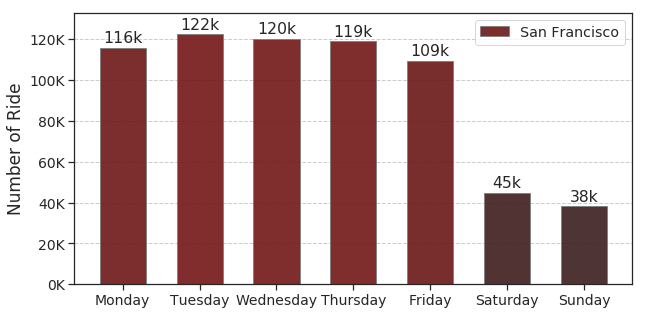

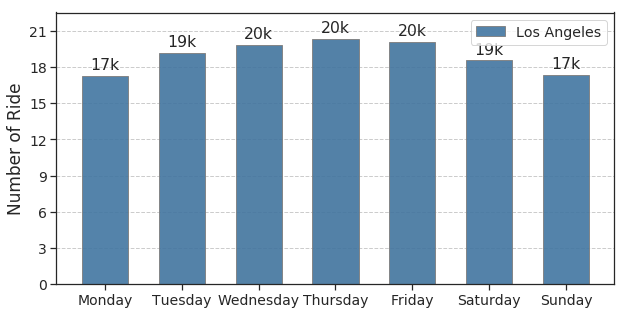

In [614]:
_sf = weekday_sf / 1000
_la = weekday_la / 1000
cm_red = sns.dark_palette('red', as_cmap=True)
cm_blue = sns.dark_palette('steelblue', as_cmap=True, reverse=True)

fig1, ax1 = plt.subplots(figsize=(10, 5))
x = range(7)
_xtick = ['', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
width = 0.6

ax1.bar(x, _sf, width, color=cm_red(_sf / _sf.sum() * 2), label='San Francisco', alpha=.9, edgecolor='gray')
ax1.legend()
ax1.set_ylabel('Number of Ride')
ax1.set_xticklabels(_xtick)
ax1.set_ylim(0, 133)
ax1.yaxis.set_major_formatter(in_k)
ax1.grid(which='major', axis='y', linestyle='--')

rects = ax1.patches
labels = [f'{i:.0f}k' for i in _sf]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 1, label,
            ha='center', va='bottom')
fig1.savefig(path.join('img', 'sf_numRide_weekDay.pdf'), format='pdf')
    
fig2, ax2 = plt.subplots(figsize=(10, 5))
ax2.bar(x, _la, width, color=cm_blue(_la / _la.sum()), label='Los Angeles', alpha=.9, edgecolor='gray')
ax2.legend()
ax2.set_ylabel('Number of Ride')
ax2.set_xticklabels(_xtick)
ax2.set_ylim(0, 22.5)
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.grid(which='major', axis='y', linestyle='--')

rects = ax2.patches
labels = [f'{i:.0f}k' for i in _la]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width() / 2, height + .3, label,
            ha='center', va='bottom')
fig2.savefig(path.join('img', 'la_numRide_weekDay.pdf'), format='pdf')

### Membership

In [617]:
import pandas  as pd

In [596]:
bike_la.columns = bike_la.columns.map(lambda x: x.replace(' ', '_') if isinstance(x, str) else x)

In [597]:
level1 = trip['subscription_type'].value_counts().sort_values() / 1000

In [598]:
level2 = bike_la.query('Passholder_Type != "Walk-up"')['Passholder_Type'].value_counts()

In [610]:
level1

Customer      103.213
Subscriber    566.746
Name: subscription_type, dtype: float64

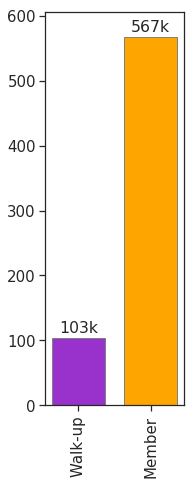

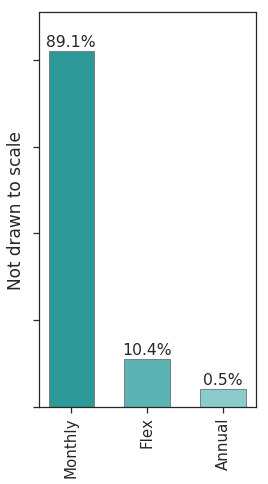

In [692]:
fig, ax = plt.subplots(figsize=(3, 7))
x = range(2)
width = .74
ax.bar(x, level1, color=['darkorchid', 'orange'], width=width, edgecolor='gray')
ax.set_xticklabels(['','Walk-up', 'Member'], rotation=90)
ax.set_ylim(0,605)
rects = ax.patches
labels = [f'{i:.0f}k' for i in level1]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
fig.tight_layout()
fig.savefig(path.join('img', 'member-ship-1.pdf'), format='pdf')

fig, ax = plt.subplots(figsize=(4, 7))
x = range(3)
width=.6
_level2 = pd.Series([82, 11, 4], index=level2.index)
_color = [sns.light_palette("teal")[i] for i in (4, 3, 2)]
ax.bar(x, _level2, width=width, color=_color, edgecolor='gray')
ax.set_yticklabels([])
ax.set_ylabel('Not drawn to scale')
ax.set_ylim(0, 91)
ax.set_xticklabels(["", 'Monthly', 'Flex', 'Annual'], rotation=90)
rects = ax.patches
labels = ['89.1%', '10.4%', '0.5%']
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + .5, label,
            ha='center', va='bottom')
fig.tight_layout()
fig.savefig(path.join('img', 'member-ship-2.pdf'), format='pdf')

In [241]:
bike_la.groupby('Passholder_Type')['Trip_Route_Category'].value_counts(normalize=True)

              Trip_Route_Category
Flex Pass     One Way                0.949249
              Round Trip             0.050751
Monthly Pass  One Way                0.953606
              Round Trip             0.046394
Staff Annual  One Way                0.782723
              Round Trip             0.217277
Walk-up       One Way                0.795095
              Round Trip             0.204905
Name: Trip_Route_Category, dtype: float64

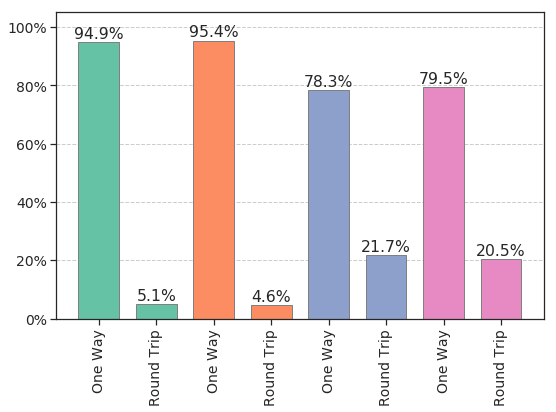

In [624]:
y = bike_la.groupby('Passholder_Type')['Trip_Route_Category'].value_counts(normalize=True).values * 100
x_tick_labels = np.insert(np.repeat([['One Way', 'Round Trip']], 4, axis=0).ravel(), 0, '')
color = np.repeat(sns.color_palette("Set2")[:4], 2, axis=0)
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(range(8), y, color=color, width=.71, edgecolor='gray')
ax.yaxis.set_major_formatter(append_perc)
ax.grid(which='major', axis='y', linestyle='--')
ax.set_xticklabels(x_tick_labels, rotation=90)
ax.set_ylim(0,105)

rects = ax.patches
labels = [f'{i:.1f}%' for i in y]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + .3, label,
            ha='center', va='bottom')

fig.tight_layout()
fig.savefig(path.join('img', 'memberShip-tripType.pdf'), format='pdf')

### Duration

In [335]:
keep = trip['duration'] <= trip['duration'].quantile(.99)
y_mean = (trip[keep].groupby(['dayofweek', 'subscription_type'])['duration'].mean() / 60).values
y_std = (trip[trip['duration'] / 60 < 30].groupby(['dayofweek', 'subscription_type'])['duration'].std() / 60).values

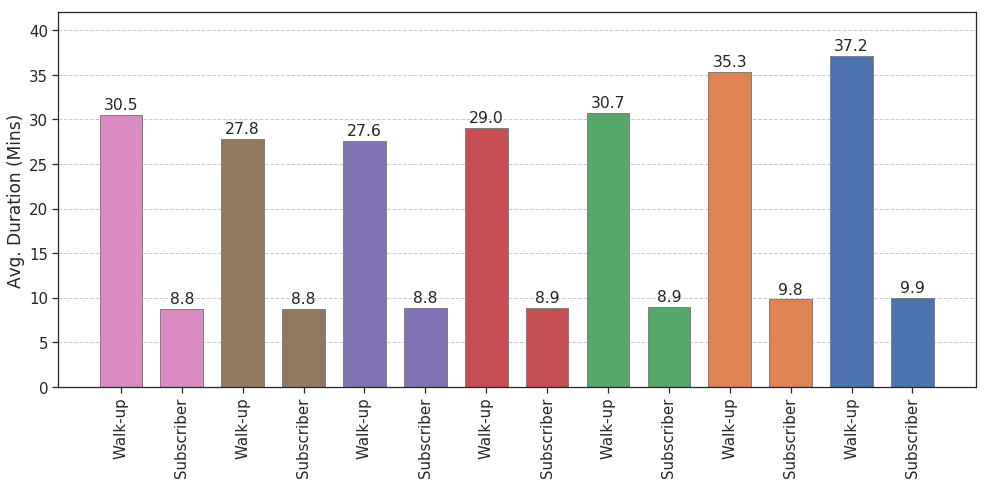

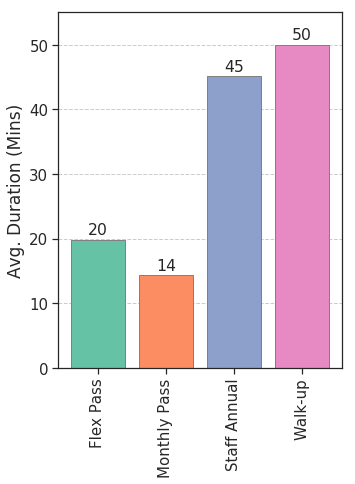

In [695]:
fig, ax = plt.subplots(figsize=(14, 7))
width=.7
x_ticklabels = np.repeat([['Walk-up', 'Subscriber']], 7, axis=0).ravel()
color = np.repeat(sns.color_palette()[:7][::-1], 2, axis=0)
# ax.bar(np.arange(14), y_mean, width=width, yerr=y_std, color=color, edgecolor='gray', capsize=5, error_kw=dict(ecolor='gray', capthick=1.5))
ax.bar(np.arange(14), y_mean, width=width, color=color, edgecolor='gray', capsize=5, error_kw=dict(ecolor='gray', capthick=1.5))
ax.set_xticks(range(14))
ax.set_xticklabels(x_ticklabels, rotation=90)
ax.grid(which='major', axis='y', linestyle='--')
ax.set_ylim(0,42)
ax.set_ylabel('Avg. Duration (Mins)')
rects = ax.patches
labels = [f'{i:.1f}' for i in y_mean]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + .3, label,
            ha='center', va='bottom')
fig.tight_layout()
fig.savefig(path.join('img', 'duration-weekday.pdf'), format='pdf')



fig, ax = plt.subplots(figsize=(5.2, 7))
y = bike_la.groupby('Passholder_Type')['Duration'].mean() / 60
color = sns.color_palette('Set2')[:4]
ax.bar(y.index, y.values, color=color, edgecolor='gray')
ax.grid(which='major', axis='y', linestyle='--')
ax.set_xticklabels(y.index, rotation=90)
ax.set_ylabel('Avg. Duration (Mins)')
ax.set_ylim(0, 55)
rects = ax.patches
labels = [f'{i:.0f}' for i in y]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + .3, label,
            ha='center', va='bottom')
fig.tight_layout()
fig.savefig(path.join('img', 'duration-membership.pdf'), format='pdf')

In [527]:
num_trips = trip.resample('M', on='start_date').size().iloc[1:, ]
max_temp_f = weather.resample('M', on='date')['max_temperature_f'].mean().iloc[1:, ]
mean_temp_f = weather.resample('M', on='date')['mean_temperature_f'].mean().iloc[1:, ]
mean_humidity = weather.resample('M', on='date')['mean_humidity'].mean().iloc[1:, ]
mean_wind_speed_mph = weather.resample('M', on='date')['mean_wind_speed_mph'].mean().iloc[1:, ]
max_wind_speed_mph = weather.resample('M', on='date')['max_wind_Speed_mph'].mean().iloc[1:, ]

# weather.set_index('date', inplace=True)
# precipitation_inches = weather.query('precipitation_inches != "T"')['precipitation_inches'].astype(float).resample('M').mean().iloc[1:, ]

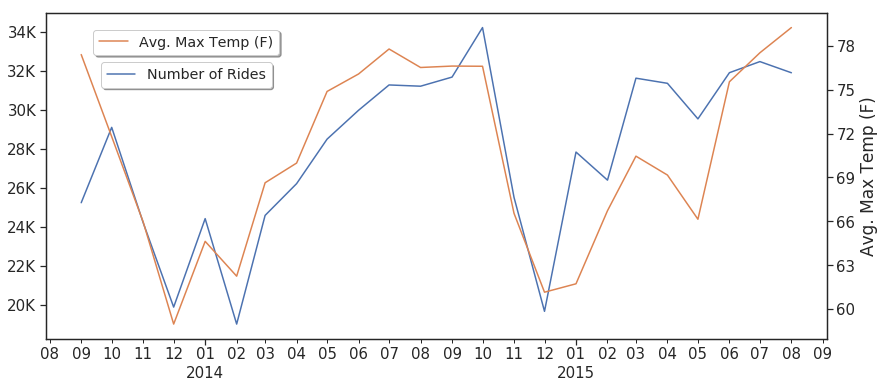

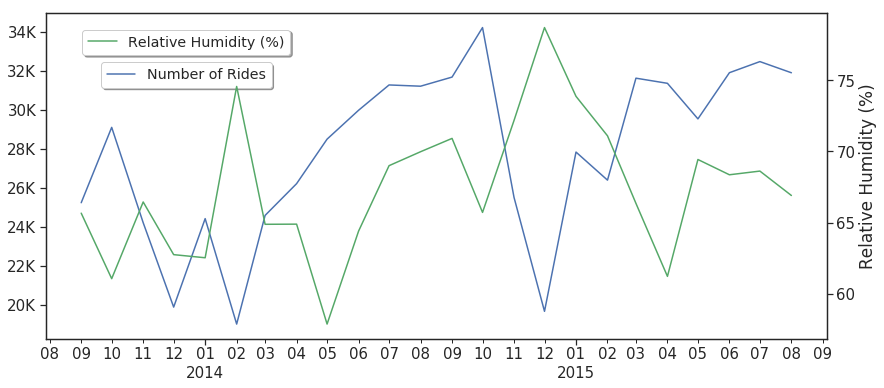

In [711]:
for _ in (num_trips, max_temp_f, mean_humidity):
    _.index = _.index.map(lambda x: pd.Timestamp(x.year, x.month, 1))
def plot_staff(var, label, color, ax, yaxis_fmt=None):
    ax_ = ax.twinx()
    ax.plot(num_trips / 1000, color=col1, label='Number of Rides')
    ax_.plot(var, color=color, label=label)
    ax.yaxis.set_major_formatter(in_k)
    ax_.set_ylabel(label)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f'{x:.0f}K'))
    years = mdates.YearLocator()    # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('\n%Y')
    moFmt = mdates.DateFormatter('%m') # (%b for Jan, Feb Mar; %m for 01 02 03)
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_minor_locator(months)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_formatter(moFmt)
    ax.legend(loc='upper center', bbox_to_anchor=(0.18, 0.87), shadow=True, ncol=2)
    ax_.legend(loc='upper center', bbox_to_anchor=(0.18, 0.97), shadow=True, ncol=2)
    if yaxis_fmt:
        ax_.yaxis.set_major_locator(yaxis_fmt)
    return ax

col1, col2, col3 = sns.color_palette()[:3]
fig, ax = plt.subplots(figsize=(14, 6))
ax = plot_staff(max_temp_f, 'Avg. Max Temp (F)', col2, ax, yaxis_fmt=MaxNLocator(integer=True))
fig.savefig(path.join('img', 'numRides-temp.pdf'))


fig, ax = plt.subplots(figsize=(14, 6))
ax = plot_staff(mean_humidity, 'Relative Humidity (%)', col3, ax, yaxis_fmt=None)
fig.savefig(path.join('img', 'numRides-humidity.pdf'))




# tax = ax.twinx()
# hax = ax.twinx()
# hax.spines['right'].set_position(('axes', 1.11))
# ax.plot(num_trips/1000, color=col1, label='Number of Rides')
# ax.set_ylabel('Number of Rides')

# tax.yaxis.set_major_locator(MaxNLocator(integer=True))

# hax.plot(mean_humidity, color=col3, label='Avg. Relative Humidity  (%)')
# hax.set_ylabel('Relative Humidity  (%)')


# years = mdates.YearLocator()    # every year
# months = mdates.MonthLocator()  # every month
# yearsFmt = mdates.DateFormatter('\n%Y')
# moFmt = mdates.DateFormatter('%m') # (%b for Jan, Feb Mar; %m for 01 02 03)
# ax.xaxis.set_major_locator(years)
# ax.xaxis.set_minor_locator(months)
# ax.xaxis.set_major_formatter(yearsFmt)
# ax.xaxis.set_minor_formatter(moFmt)


# ax.legend(loc='upper center', bbox_to_anchor=(0.15, 1.15), shadow=True, ncol=2)
# tax.legend(loc='upper center', bbox_to_anchor=(0.8, 1.25), shadow=True, ncol=2)
# hax.legend(loc='upper center', bbox_to_anchor=(0.8, 1.15), shadow=True, ncol=2)
# # for _ in (ax, tax, hax):
# #     _.legend()

# fig.tight_layout()
# fig.savefig(path.join('img', 'numRides-Temp-Humid.pdf'), format='pdf')

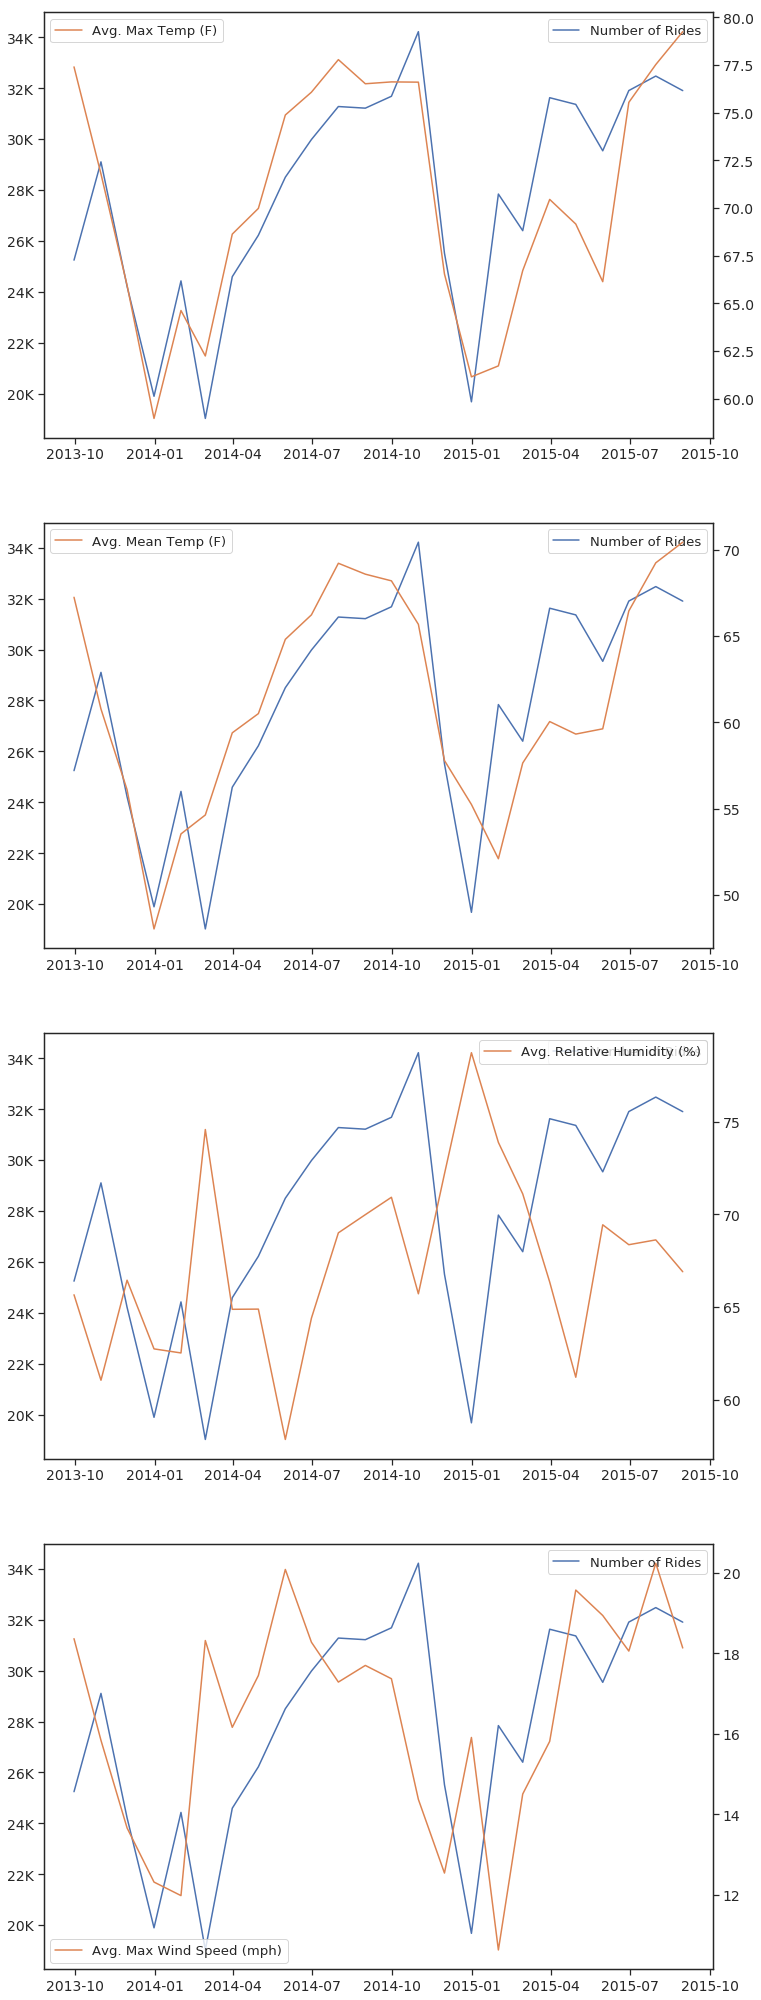

In [528]:
def two_lines(var1, var2, label1, label2, ax):
    col1, col2 = sns.color_palette()[:2]
    ax_ = ax.twinx()
    ax.plot(var1, color=col1, label=label1)
    ax_.plot(var2, color=col2, label=label2)
    ax.legend()
    ax.yaxis.set_major_formatter(in_k)
    ax_.legend()
    return ax
fig, axes = plt.subplots(4, figsize=(12, 36))
    
two_lines(num_trips/1000, max_temp_f, 'Number of Rides', 'Avg. Max Temp (F)', axes[0])
two_lines(num_trips/1000, mean_temp_f, 'Number of Rides', 'Avg. Mean Temp (F)', axes[1])
two_lines(num_trips/1000, mean_humidity, 'Number of Rides', 'Avg. Relative Humidity (%)', axes[2])
two_lines(num_trips/1000, max_wind_speed_mph, 'Number of Rides', 'Avg. Max Wind Speed (mph)', axes[3])

In [521]:
summer = trip[(trip['start_date'].dt.month.isin((6, 7, 8, 9))) & (trip['start_date'].dt.year == 2014)]
sum_weat = weather[(weather['date'].dt.month.isin((6, 7, 8, 9))) & (weather['date'].dt.year == 2014)]

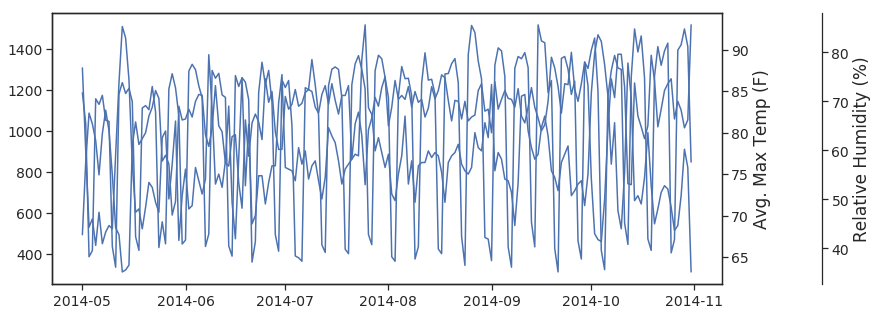

In [523]:
num_trips = summer.resample('D', on='start_date').size()
max_temp_f = sum_weat.resample('D', on='date')['max_temperature_f'].mean()
mean_humidity = sum_weat.resample('D', on='date')['mean_humidity'].mean()
fig, ax = plt.subplots(figsize=(12, 5))
tax = ax.twinx()
hax = ax.twinx()
tax.set_ylabel('Avg. Max Temp (F)')
hax.set_ylabel('Relative Humidity (%)')
hax.spines['right'].set_position(('axes', 1.15))
ax.plot(num_trips)
tax.plot(max_temp_f)
hax.plot(mean_humidity)

### Start from here, I got inspired by some ideas that involved in inferences, and I started thinking about working on the second visualization. 

In [717]:
bike_la['Starting_Station_ID'].value_counts().head(20)

3069.0    5138
3030.0    5059
3005.0    4883
3064.0    4661
3031.0    4629
3014.0    4571
3042.0    4015
3082.0    3908
3022.0    3893
3067.0    3797
3035.0    3406
3038.0    3306
3055.0    3270
3068.0    3252
3049.0    3154
3034.0    3037
3048.0    3005
3063.0    2949
3007.0    2785
3006.0    2708
Name: Starting_Station_ID, dtype: int64

In [720]:
trip[trip['duration'] / 60 > 1000]['start_station_name'].value_counts().head(25)

Harry Bridges Plaza (Ferry Building)        34
Powell Street BART                          33
University and Emerson                      28
Mountain View Caltrain Station              26
Market at 4th                               26
Embarcadero at Vallejo                      24
Market at 10th                              24
Embarcadero at Sansome                      22
Steuart at Market                           21
Embarcadero at Bryant                       21
Park at Olive                               21
Palo Alto Caltrain Station                  20
Civic Center BART (7th at Market)           20
Powell at Post (Union Square)               19
San Jose Civic Center                       19
San Antonio Caltrain Station                19
2nd at Townsend                             18
California Ave Caltrain Station             18
Rengstorff Avenue / California Street       18
Market at Sansome                           17
San Francisco Caltrain (Townsend at 4th)    16
Grant Avenue 